## JPEG dataloader performance 

Setup a conda environment like so

```bash
$ conda create -n playground -c pytorch -c conda-forge \
  python=3.8 pytorch torchvision cudatoolkit=11.0 numpy pandas matplotlib gxx_linux-64
$ conda activate playground
```  

Now install OpenCV and DALI from pip

```
$ pip install opencv-python tqdm
$ pip install --extra-index-url https://developer.download.nvidia.com/compute/redist nvidia-dali-cuda110
```

Now follow the dance of installing a libjpeg-turbo backed Pillow-SIMD install

```bash
# The following steps are based on
# https://docs.fast.ai/performance.html#installation

$ conda uninstall -y --force jpeg libtiff
$ conda install -y -c conda-forge libjpeg-turbo --no-deps
$ pip uninstall -y pillow
$ export CXX=x86_64-conda-linux-gnu-g++
$ export CC=x86_64-conda-linux-gnu-gcc
$ CFLAGS="$CFLAGS -mavx2" pip install --upgrade --no-cache-dir --force-reinstall --no-binary :all: --compile pillow-simd

# Reinstall libraries
$ conda install -c conda-forge jpeg libtiff
```

In [120]:
import re
from io import BytesIO
from typing import Callable, TypeVar, Optional

import cv2
import numpy as np
import PIL.features
import PIL.Image
import simplejpeg
import torch
import torchvision
from tqdm import trange
from time import time

In [48]:
assert PIL.features.check_feature("libjpeg_turbo")

In [47]:
cv2_jpeg_lib = re.search(
    r".*JPEG:\W+(?P<jpeg_lib>.*)", cv2.getBuildInformation()
).groupdict()["jpeg_lib"]
print(cv2_jpeg_lib)
assert "turbo" in cv2_jpeg_lib

libjpeg-turbo (ver 2.0.6-62)


In [49]:
!wget "https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg" -O img.jpg

--2021-02-25 20:59:41--  https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28208 (28K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  27.55K  --.-KB/s    in 0.02s   

2021-02-25 20:59:41 (1.25 MB/s) - ‘img.jpg’ saved [28208/28208]



(273, 369, 3)


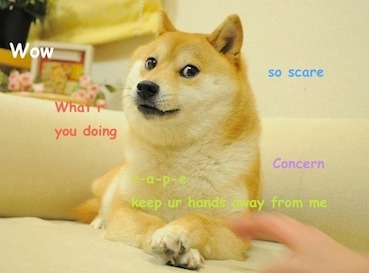

In [170]:
img_pil = PIL.Image.open("img.jpg")
img  = np.asarray(img_pil).copy()
print(img.shape)
img_pil

---
## Decoding functions

In [59]:
with open("img.jpg", "rb") as f:
    img_bytes = f.read()

In [62]:
def opencv_decode(img_bytes: bytes) -> np.ndarray:
    img_np = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
    return cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)


opencv_decode(img_bytes).shape

(273, 369, 3)

In [63]:
def simplejpeg_decode(img_bytes: bytes) -> np.ndarray:
    return simplejpeg.decode_jpeg(img_bytes, fastdct=True, fastupsample=True)


simplejpeg_decode(img_bytes).shape

(273, 369, 3)

In [68]:
def pillow_decode(img_bytes) -> np.ndarray:
    with BytesIO(img_bytes) as f:
        return np.asarray(PIL.Image.open(f))


pillow_decode(img_bytes).shape

(273, 369, 3)

In [90]:
def torchvision_decode(img_bytes) -> torch.Tensor:
    return torchvision.io.decode_image(
        torch.ByteTensor(torch.ByteStorage.from_buffer(img_bytes))
    )


torchvision_decode(img_bytes).shape

torch.Size([3, 273, 369])

In [84]:
batch_size = 16 * 16
batch_size

256

---
## Micro benchmarks

In [69]:
%%timeit
opencv_decode(img_bytes)

1.64 ms ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
%%timeit
simplejpeg_decode(img_bytes)

457 µs ± 4.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [71]:
%%timeit
pillow_decode(img_bytes)

728 µs ± 5.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [82]:
%%timeit
torchvision_decode(img_bytes)

1.37 ms ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


---
## Marginally more realistic benchmarks

In [104]:
device = torch.device('cuda:0')

In [108]:
def np_hwc_to_chw(arr):
    return torch.from_numpy(arr.transpose((2, 0, 1)))

In [101]:
T = TypeVar("T")


class CPUImageDataset:
    def __init__(
        self,
        loader_fn: Callable[[bytes], T],
        img_bytes: bytes,
        transform: Optional[Callable[[T], torch.Tensor]] = None,
    ):
        self.loader_fn = loader_fn
        self.img_bytes = img_bytes
        self.transform = transform if transform is not None else lambda x: x

    def get_batch(self, batch_size):
        return torch.stack(
            [self.transform(self.loader_fn(self.img_bytes)) for _ in range(batch_size)]
        )

In [133]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator

In [146]:
class DALIPipeline(Pipeline):
    def __init__(self, img_bytes, max_batch_size, device_id=0, n_threads=1):
        super().__init__(max_batch_size, n_threads, device_id, seed=42)
        self.img_bytes = np.frombuffer(img_bytes, np.uint8)
        self.jpeg_bytes_op = ops.ExternalSource()
        self.decode_op = ops.ImageDecoder(device='mixed', output_type=types.RGB)
    
    def iter_setup(self):
        self.feed_input(self.jpeg_bytes, [self.img_bytes for _ in range(self.max_batch_size)])
    
    def define_graph(self):
        self.jpeg_bytes = self.jpeg_bytes_op()
        return self.decode_op(self.jpeg_bytes)

In [156]:
pipeline = DALIPipeline(img_bytes, max_batch_size=batch_size)
#dali_dataset = DALIGenericIterator(pipeline, ["images"])



In [191]:
import ctypes
import nvidia.dali.types as dali_types
pipeline.build()
stream = torch.cuda.current_stream(device)


def get_dali_batch() -> torch.Tensor:
    # Taken from feed_ndarray
    # from https://github.com/NVIDIA/DALI/blob/45e21f62dabf132459030e752532bdacae33a727/dali/python/nvidia/dali/plugin/pytorch.py#L38
    out = pipeline.run()[0]
    torch_out = torch.empty((batch_size, ) + img.shape, dtype=torch.uint8, device=device)
    out.copy_to_external(ctypes.c_void_p(torch_out.data_ptr()), cuda_stream=ctypes.c_void_p(dali_types._raw_cuda_stream(stream)))
    return torch_out

In [125]:
datasets = {
    'simplejpeg': CPUImageDataset(simplejpeg_decode, img_bytes, transform=np_hwc_to_chw),
    'opencv2': CPUImageDataset(opencv_decode, img_bytes, transform=np_hwc_to_chw),
    'pillow': CPUImageDataset(pillow_decode, img_bytes, transform=np_hwc_to_chw),
    'torchvision': CPUImageDataset(torchvision_decode, img_bytes),
}

n_warmup_runs = 3
n_runs = 10
for name, dataset in datasets.items():
    for _ in range(n_warmup_runs):
        dataset.get_batch(batch_size).to(device)
    timings = []
    for _ in trange(n_runs):
        torch.cuda.synchronize(device)
        before = time()
        dataset.get_batch(batch_size).to(device)
        torch.cuda.synchronize(device)
        timings.append(time() - before)
    print(f"{name}: {np.mean(timings):.5f}, {np.std(timings):.5f}")

100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


simplejpeg: 0.19784, 0.00023


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


opencv2: 0.73937, 0.04351


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


pillow: 0.31235, 0.00219


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

torchvision: 0.46944, 0.00837


In [193]:
for _ in range(n_warmup_runs):
    get_dali_batch()
timings = []
for _ in trange(n_runs):
    torch.cuda.synchronize(device)
    before = time()
    get_dali_batch()
    torch.cuda.synchronize(device)
    timings.append(time() - before)
print(f"dali: {np.mean(timings):.5f}, {np.std(timings):.5f}")

100%|██████████| 10/10 [00:01<00:00,  9.84it/s]

dali: 0.10076, 0.00254
